In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")

In [94]:
## BLS data from https://www.bls.gov/cps/cpsaat11.htm
## Clean BLS data 

df_bls = pd.read_csv('BLS_occupational_demographics_clean.csv')

# missing data in BLS csv file are "-". Make them NaN
df_bls.replace('-',np.nan,inplace=True)
# Check column names. Find that occupation has a trailing space, which will mess up merge.
df_bls.columns
df_bls.rename(columns={'Occupation ':'Occupation'}, inplace=True)
print(df_bls.shape)

# Scan occupations with missing data. (< 50,000 employees in each; 210 total)
null_data = df_bls[df_bls.isnull().any(axis=1)]
null_data = null_data.apply(pd.to_numeric, errors='ignore')
null_data.sort_values(['Total Employed'], ascending=False, inplace=True)

dropped_n = null_data['Total Employed'].sum()
total_n = 153337
print(round(dropped_n/total_n, 2))
# employment from dropped categories is negligible.

# drop rows with missing data.
df_bls.dropna(axis=0, how='any', inplace=True)
print(df_bls.shape)

(540, 8)
0.03
(334, 8)


In [95]:
## Clean Exposure data 
## Exposure data from https://www.sciencedirect.com/science/article/pii/S0040162516302244#s0110
df_exposure = pd.read_csv('Frey_Osborne_appendix.csv')

# can drop column = Label (which was used to train ML algorithm)
df_exposure.columns
df_exposure.drop(['Label'], axis=1, inplace=True)

In [96]:
## Join datasets
df_joined = pd.merge(df_bls, df_exposure, on='Occupation')

In [97]:
# Convert to numeric, in two steps because Total Employed has commas
df_joined = df_joined.apply(pd.to_numeric, errors='ignore')
df_joined['Total Employed'] = pd.to_numeric(df_joined['Total Employed'].astype(str).str.replace(',',''), errors='coerce')

In [98]:
# What's left? 62% of workforce.
print(df_joined.shape)
remaining_n = df_joined['Total Employed'].sum()
print(round(remaining_n/total_n, 2))

(210, 11)
0.62


In [99]:
# Is what's left similar to what we had to drop?
df_bls = df_bls.apply(pd.to_numeric, errors='ignore')

cols = ['White', 'Black', 'Asian', 'Hispanic']
for c in cols:
    print(c+' difference in means', df_joined[c].mean() - df_bls[c].mean())
    print(c+' difference in std', df_joined[c].std() - df_bls[c].std())
    print(c+' difference in min', df_joined[c].min() - df_bls[c].min())
# differences in means and standard deviations are not large

White difference in means 0.26231251782144227
White difference in std -0.43868956466638487
White difference in min 23.5
Black difference in means 0.002318220701450713
Black difference in std 0.009115436299482305
Black difference in min 0.0
Asian difference in means -0.11342172797263217
Asian difference in std -1.067482204097753
Asian difference in min 0.0
Hispanic difference in means -0.36098089535215294
Hispanic difference in std -0.6193837533110376
Hispanic difference in min 0.0


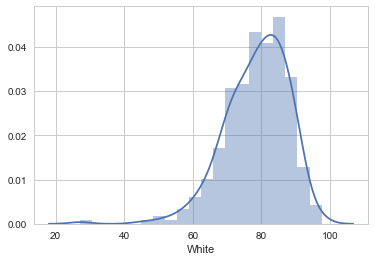

In [100]:
sns.distplot(df_bls['White'])

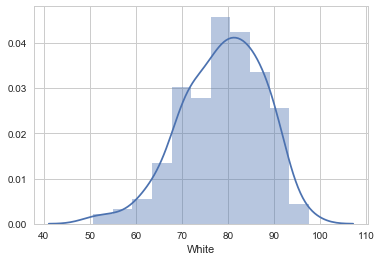

In [101]:
sns.distplot(df_joined['White'])
# joined data gets rid of some of the left tail. Mean is similar, and standard deviation is close (not identical).

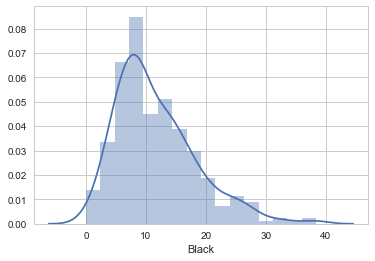

In [102]:
sns.distplot(df_bls['Black'])

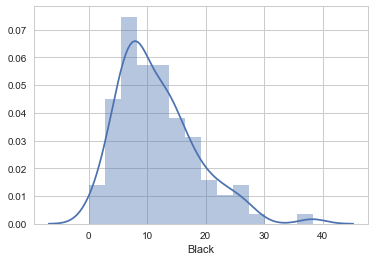

In [103]:
sns.distplot(df_joined['Black'])

Black data looks very similar. We have some indication that the occupations for which we have both automation and demographic data are similar to the occupations for which we only have demographic data. 

In [104]:
# Create variables that measure racial over-representativeness. 
# Data from: https://www.bls.gov/opub/reports/race-and-ethnicity/2016/home.htm
# In these figures, hispanics can also be included in other races (this is the same as the BLS data)
df_joined['White_Rep'] = df_joined['White'] - 78
df_joined['Black_Rep'] = df_joined['Black'] - 12
df_joined['Asian_Rep'] = df_joined['Asian'] - 6
df_joined['Hispanic_Rep'] = df_joined['Hispanic'] - 17

In [6]:
# in checks, don't include hispanic -- they could be of any race (White, black, or Asian)
# df_joined['Check_Rep'] = df_joined['White_Rep'] + df_joined['Black_Rep'] + df_joined['Asian_Rep']
# df_joined['Check_Rep'].describe()
# df_joined['Check_Pct'] = df_joined['White'] + df_joined['Black'] + df_joined['Asian']
# df_joined['Check_Pct'].describe()

count    210.000000
mean      14.328095
std        1.773835
min        8.520000
25%       13.320000
50%       14.520000
75%       15.520000
max       17.520000
Name: Check_Rep, dtype: float64

In [107]:
# Show correlation between over-representativeness and likelihood of automation. This is by occupation.
cols = ['White_Rep', 'Black_Rep', 'Asian_Rep', 'Hispanic_Rep']
for c in cols:
    print('Correlation between probility of automation and {0} is {1:f}.'.format(c, round(df_joined['Probability'].corr(df_joined[c]),4)))

Correlation between probility of automation and White_Rep is -0.183200.
Correlation between probility of automation and Black_Rep is 0.291700.
Correlation between probility of automation and Asian_Rep is -0.195500.
Correlation between probility of automation and Hispanic_Rep is 0.448100.


# Plotting

## Non-White

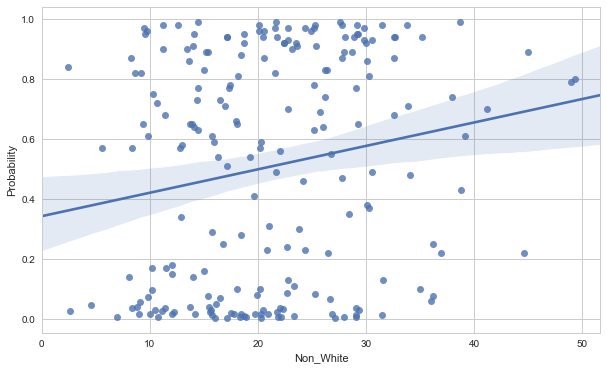

In [108]:
plt.figure(figsize=(10,6))
sns.despine()
sns.set_style("whitegrid")

df_joined['Non_White'] = 100 - df_joined['White']
sns.regplot(x='Non_White', y='Probability', data=df_joined)

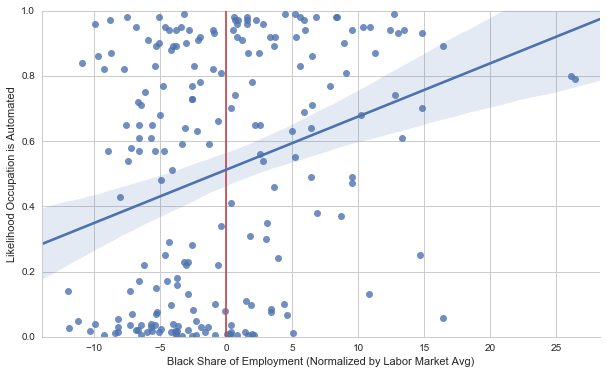

In [120]:
plt.figure(figsize=(10,6))
plt.axvline(x=0, color='r')
sns.despine()
sns.set_style("whitegrid")

# Now using over-representiveness
nw = sns.regplot(x='Black_Rep', y='Probability', data=df_joined)
nw.set_ylim(0,1)
plt.ylabel("Likelihood Occupation is Automated")
plt.xlabel("Black Share of Employment (Normalized by Labor Market Avg)")
plt.savefig("black_regplot.png")

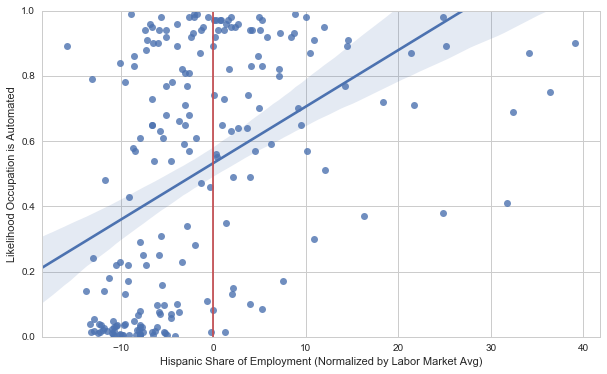

In [121]:
plt.figure(figsize=(10,6))
sns.despine()
sns.set_style("whitegrid")

# Now using over-representiveness
f = sns.regplot(x='Hispanic_Rep', y='Probability', data=df_joined)
f.set_ylim(0,1)
plt.axvline(x=0, color='r')
plt.ylabel("Likelihood Occupation is Automated")
plt.xlabel("Hispanic Share of Employment (Normalized by Labor Market Avg)")
plt.savefig("hisp_regplot.png")

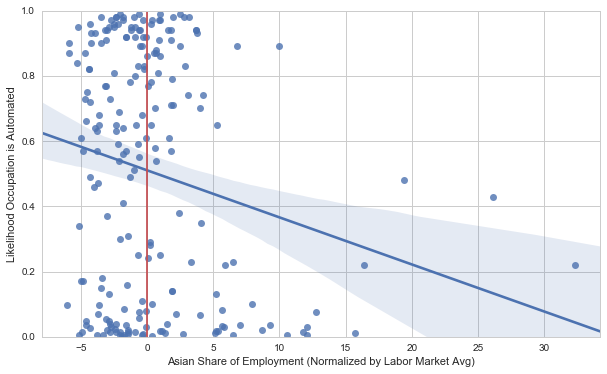

In [122]:
plt.figure(figsize=(10,6))
sns.despine()
sns.set_style("whitegrid")

# Now using over-representiveness
f = sns.regplot(x='Asian_Rep', y='Probability', data=df_joined)
f.set_ylim(0,1)
plt.axvline(x=0, color='r')
plt.ylabel("Likelihood Occupation is Automated")
plt.xlabel("Asian Share of Employment (Normalized by Labor Market Avg)")
plt.savefig("asian_regplot.png")

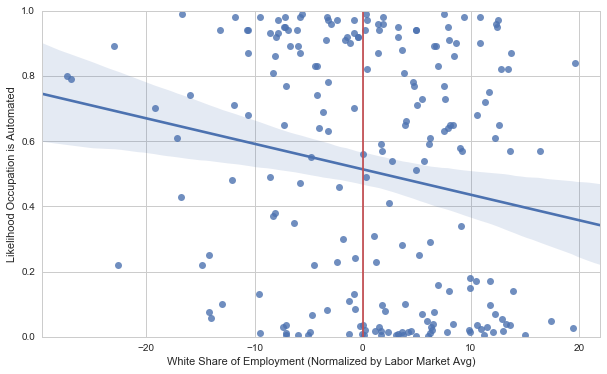

In [123]:
plt.figure(figsize=(10,6))
sns.despine()
sns.set_style("whitegrid")

# Now using over-representiveness
f = sns.regplot(x='White_Rep', y='Probability', data=df_joined)
f.set_ylim(0,1)
plt.axvline(x=0, color='r')
plt.ylabel("Likelihood Occupation is Automated")
plt.xlabel("White Share of Employment (Normalized by Labor Market Avg)")
plt.savefig("white_regplot.png")

# Tables

In [106]:
df_joined.sort_values(['Black_Rep','Probability'], ascending=[False, False], inplace=True)
df_joined.head(5)

,Occupation,Total Employed,Women,White,Black,Asian,Hispanic,Rank,Probability,SOC code,White_Rep,Black_Rep,Asian_Rep,Check_Pct,Hispanic_Rep,Non_White,Black_Employment
151,"Postal service mail sorters, processors, and p...",50,56.7,51.0,38.4,7.9,3.8,430,0.790,43-5053,-27.0,26.4,1.9,97.3,-13.2,49.0,1920.0
114,Barbers,135,15.6,50.7,38.1,5.1,24.1,439,0.800,39-5011,-27.3,26.1,-0.9,93.9,7.1,49.3,5143.5
201,Taxi drivers and chauffeurs,674,18.9,55.0,28.4,12.8,17.0,531,0.890,53-3041,-23.0,16.4,6.8,96.2,0.0,45.0,19141.6
87,Licensed practical and licensed vocational nurses,630,89.5,64.0,28.4,5.4,12.4,144,0.058,29-2061,-14.0,16.4,-0.6,97.8,-4.6,36.0,17892.0
209,Refuse and recyclable material collectors,94,11.7,70.2,26.8,2.1,24.2,585,0.930,53-7081,-7.8,14.8,-3.9,99.1,7.2,29.8,2519.2


In [107]:
df_joined['Black_Employment'] = df_joined['Total Employed'] * df_joined['Black']
df_joined.sort_values(['Black_Employment'], ascending=[False], inplace=True)
df_joined.head(5)

,Occupation,Total Employed,Women,White,Black,Asian,Hispanic,Rank,Probability,SOC code,White_Rep,Black_Rep,Asian_Rep,Check_Pct,Hispanic_Rep,Non_White,Black_Employment
120,Cashiers,3253,72.7,70.2,17.9,6.4,22.3,657,0.970,41-2011,-7.8,5.9,0.4,94.5,5.3,29.8,58228.7
138,Customer service representatives,2494,65.1,73.2,17.2,5.4,17.4,315,0.550,43-4051,-4.8,5.2,-0.6,95.8,0.4,26.8,42896.8
123,Retail salespersons,3235,48.2,77.6,12.8,5.7,17.2,570,0.920,41-2031,-0.4,0.8,-0.3,96.1,0.2,22.4,41408.0
84,Registered nurses,3159,89.9,76.7,12.3,8.7,6.9,46,0.009,29-1111,-1.3,0.3,2.7,97.7,-10.1,23.3,38855.7
117,Personal care aides,1365,83.7,62.0,24.8,9.1,20.7,406,0.740,39-9021,-16.0,12.8,3.1,95.9,3.7,38.0,33852.0


In [ ]:
# run simple OLS regression
# probability = B_0 + B_1*Black_Rep + B_2*Asian_Rep + B_3*Hispanic_Rep (white is ommitted category) 
# maybe I should normalize over-rep? So a one percentage point increase in the labor market associated with...

# Cross tab

In [ ]:
cols = ['White_Rep', 'Black_Rep', 'Asian_Rep', 'Hispanic_Rep']
for c in cols:
    np.where((df_joined['Probability'] > 0.5) & (df_joined[c] > 0))

In [131]:
top_right = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['Black_Rep'] > 0),1,0))
bottom_right = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['Black_Rep'] > 0),1,0))
bottom_left = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['Black_Rep'] < 0),1,0))
top_left = bottom_left = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['Black_Rep'] < 0),1,0))

In [132]:
print(top_left, top_right)
print(bottom_left, bottom_right)

57 59
57 31


In [133]:
# Do the same for whites
top_right = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['White_Rep'] > 0),1,0))
bottom_right = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['White_Rep'] > 0),1,0))
bottom_left = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['White_Rep'] < 0),1,0))
top_left = bottom_left = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['White_Rep'] < 0),1,0))
print(top_left, top_right)
print(bottom_left, bottom_right)

54 61
54 58


In [134]:
# Do the same for hispanics
top_right = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['Hispanic_Rep'] > 0),1,0))
bottom_right = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['Hispanic_Rep'] > 0),1,0))
bottom_left = np.sum(np.where((df_joined['Probability'] < 0.5) & (df_joined['Hispanic_Rep'] < 0),1,0))
top_left = bottom_left = np.sum(np.where((df_joined['Probability'] > 0.5) & (df_joined['Hispanic_Rep'] < 0),1,0))
print(top_left, top_right)
print(bottom_left, bottom_right)

54 61
54 13
